# Splitter cells  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RatInABox-Lab/RatInABox/blob/dev/demos/splitter_cell_example.ipynb)

In this demo we'll show a very simple way one could model 'splitter cells' using RatInABox. A known type of splitter cells fire in the central arm of a figure-8 maze _selectively_ dependent on whether the agent just came from the _left_  or the _right_ arm. 

To replicate this observation we'll:

1. Generate a figure-8 `Εnvironment`
2. Add an `Αgent` to the environment and have it to run around the figure-8
4. Write a `SplitterCells` class (subclass of `PlaceCells`) which gate activity dependent on the `Agents` recent history.

In [1]:
# Install dependencies 
!pip install ratinabox
!pip install sklearn

#Import ratinabox 
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import PlaceCells, FeedForwardLayer

#stylize plots and set figure directory for saving 
ratinabox.stylize_plots(); ratinabox.autosave_plots=True; ratinabox.figure_directory="../figures/"

#...and other dependencies
import numpy as np 
import copy 
import matplotlib
import matplotlib.pyplot as plt

## Figure-8 `Environment`

In this section we'll construct a figure-8 environment and an update loop which stores the arm the agent is in.

The environment is summarised as follows (see figure below):

<img src="../.images/demos/figure8.png" width="500" align="center">

This is the code for making that - to keep it tidy we'll make a subclass of `Environment` called `Figure8Environment` which does it all at initialisation. Specifically this
* Does some basic geometry to construct the `boundary` and `holes` of the figure 8 (these are just lists of coordinates) and passes those to the paraent class `Environment` which constructs the environment.
* Also creates an attribute `Env.trigger_lines` which the `Agent` can use to know which arm it is (or was) recently in. The dashed trigger line represents movement into the left arm and the dotted trigger line represents movement into the right arm.


In [2]:
#Make a figure-8 Environment
class Figure8Environment(Environment):
    """This class, a subclass of riab.Environment, defines a figure-8 environment. The __init__ function handles creating the boundaries and holes correctly and storing the 'trigger lines'"""
    
    default_params = {
        # These params define the scale parameters for the figure-8 
        'L' : 0.8, #length of centre arm 
        'W' : 0.2, #width of figure-8 track
        'R' : 0.5, #inner radius of the figure-8 loops
        'DU': 0.1, #angular resolution of wall segments
        }
    
    def __init__(self, params={}):
        self.params = copy.deepcopy(__class__.default_params)
        self.params.update(params)

        #GEOMETRY
        L, W, R, DU = self.params['L'], self.params['W'], self.params['R'], self.params['DU']
        #some basic geometry (feel free to ignore)
        R2 = R + W #outer radius
        THETA1 = np.arcsin(L/(2*R)) #anglular extent of outer loop segments
        THETA2 = np.arccos((R*np.cos(THETA1)+W/2)/(R+2*W/2)) #angular extent of inner loop segments
        OS = R * np.cos(THETA1) + W/2 #offset of the figure-8 arm loops from origin
        self.OS, self.THETA1 = OS, THETA1 #store these for later use 
        #Make arrays of all the points on the outer boundary and the two central holes 
        left_loop = np.array([[R2*np.cos(t)-OS,R2*np.sin(t)] for t in np.arange(THETA2,2*np.pi-THETA2,DU)])
        right_loop = np.array([[R2*np.cos(t)+OS,R2*np.sin(t)] for t in np.arange(-np.pi+THETA2,np.pi-THETA2,DU)])
        boundary = np.vstack([left_loop,right_loop])
        left_hole = np.array([[R*np.cos(t)-OS,R*np.sin(t)] for t in np.arange(THETA1,2*np.pi-THETA1,DU)])
        right_hole = np.array([[R*np.cos(t)+OS,R*np.sin(t)] for t in np.arange(-np.pi+THETA1,np.pi-THETA1,DU)])
        
        #TRIGGER LINES
        self.trigger_lines = np.array([
                              [[-OS,R],[-OS,R2]], #left arm trigger line 
                              [[OS,R],[OS,R2]],   #right arm trigger line
                              ])
    
        #Pass these into the super class init function
        self.params['boundary'] = boundary
        self.params['holes'] = [left_hole, right_hole]
        
        super().__init__(params=self.params)

        return
    
    def plot_environment(self, fig=None, ax=None, autosave=None):
        fig, ax = super().plot_environment(fig, ax, autosave)
        #plot the trigger lines
        ax.plot(self.trigger_lines[0,:,0], self.trigger_lines[0,:,1], color='k',linestyle='dashed',zorder=1)
        ax.plot(self.trigger_lines[1,:,0], self.trigger_lines[1,:,1], color='k',linestyle='dotted',zorder=1)

        return fig, ax


Now add the `Agent`. To keep things cleann we'll write a new subclass of `Agent` which we'll call `Figure8Agent`. This `Agent` will:
* Have an `Agent.last_lap_arm` attribute to "remember" which arm it's in.
* Update this attribute whenever it crosses a trigger line and save it to history on each time step. 
* Move according to a policy which takes it around the figure*maxearm and a list in it's history to save this. We'll do this all in the `__init__()` function.

The function `agent_policy` is a simple function that takes the agents position and returns a velocity vector along which the agent should move (the orange arrows in the diagram).

In [3]:
class Figure8Agent(Agent):
    """This class, a subclass of riab.Agent, defines an agent which can navigate the figure-8 environment. The __init__ function handles initialising the agent's position and storing the last lap arm"""
    
    default_params = {} #no params needed for this agent
    
    def __init__(self, Env, params={}):
        super().__init__(Env, params)
        assert isinstance(Env, Figure8Environment), "Figure8Agent must be initialised with a Figure8Environment"
        self.last_lap_arm = ("left" if self.pos[0]<0 else "right")
        self.history['last_lap_arm'] = []
        self.history['left_trigger_times'] = []
        self.history['right_trigger_times'] = []
    
    def update(self, **kwargs):
        super().update(drift_velocity = self.figure_8_policy(self.pos))
        self.history['last_lap_arm'].append(self.last_lap_arm)
        if len(self.history['t']) > 1:
            last_step = np.array([self.history['pos'][-1],self.history['pos'][-2]]).reshape(1,2,2)
            #You could write the intercept logic however you want but we'll use a RiaB utils function to do it cleanly. `vector_intercepts` returns a boolean array specifying if any on the vectors in array_1 intercepted with those in array_2 so we can use this to tell if the Agent crossed a trigger line 
            if True in (p := ratinabox.utils.vector_intercepts(
                vector_list_a = last_step,
                vector_list_b = Env.trigger_lines,
                return_collisions = True,
                )):
                if p[0][0]: 
                    self.last_lap_arm = "left"
                    self.history['left_trigger_times'].append(self.t)
                elif p[0][1]:
                    self.last_lap_arm = "right"
                    self.history['right_trigger_times'].append(self.t)



    # POLICY 
    def figure_8_policy(self, pos):
        """Returns a velocity vector which causes the Agent to move round the figure-8"""
        OS, W, R, THETA1 = self.Environment.OS, self.Environment.W, self.Environment.R, self.Environment.THETA1
        left_centre, right_centre = np.array([-OS,0]) , np.array([OS,0])
        if np.abs(pos[0]) < W/2 and np.abs(pos[1]) < R*np.sin(THETA1): # in the centre arm --> move up
            drift_dir = np.array([-4*pos[0],1]) #slight drift towards centre line makes next loop "random" 
        elif pos[0] < 0: # left arm --> move anticlockwise 
            [x,y] = pos - left_centre
            drift_dir= np.array([-y,x])
        elif pos[0] > 0: # right arm --> move clockwise
            [x,y] = pos - right_centre
            drift_dir = np.array([y,-x])
        return 0.2 * drift_dir / np.linalg.norm(drift_dir)

Run an agents for 200 seconds then plot the agents trajectory.

Figure saved to /Users/tomgeorge/Documents/RatInABox/figures/12_10_23/trajectory_0049.png  & .svg


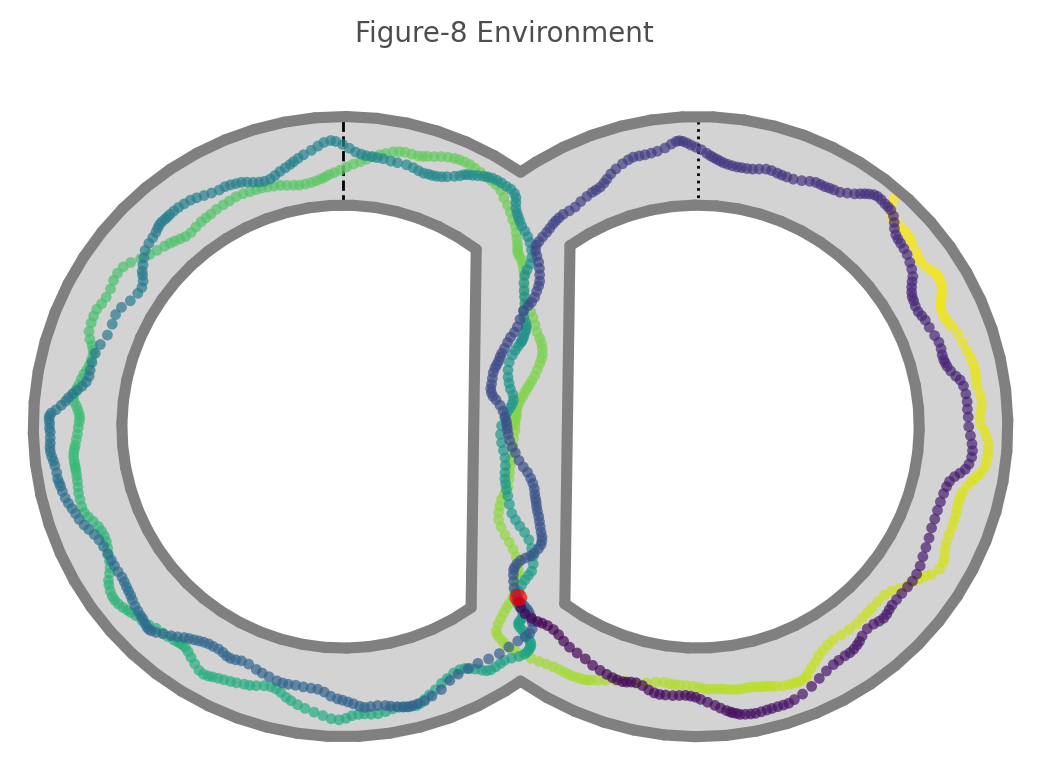

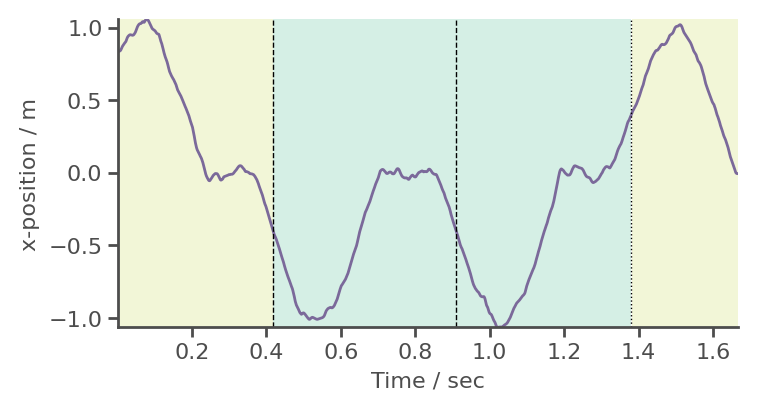

In [4]:
Env = Figure8Environment()
Ag = Figure8Agent(Env)
while Ag.t < 100: 
    Ag.update()

# Plot the trajectory 
fig, ax = Ag.plot_trajectory(color="changing")
fig.suptitle("Figure-8 Environment")

def display_last_arm(fig, ax, Ag):
    last_switch_id = 0 
    laps = Ag.history['last_lap_arm']
    triggers = Ag.history['left_trigger_times']
    t = np.array(Ag.history['t'])
    for i,lap in enumerate(laps):
        if (i > 0 and lap != laps[i-1]) or (i == len(laps)-1):
            ax.axvspan(t[last_switch_id+1]/60,t[i]/60,color=("C2" if laps[last_switch_id]=='left' else "C3"),alpha=0.2,lw=0)
            last_switch_id = i
    for trigger_time in Ag.history['left_trigger_times']:
        ax.axvline(trigger_time/60,color='k',ls='dashed',lw=0.5)
    for trigger_time in Ag.history['right_trigger_times']:
        ax.axvline(trigger_time/60,color='k',ls='dotted',lw=0.5)
    return fig, ax

def show_1D_trajectory(Ag):
    #Show the x-position alongside the last lap arm
    fig, ax = plt.subplots(1,1,figsize=(4,2))
    t = np.array(Ag.history['t'])
    pos = np.array(Ag.history['pos'])
    ax.plot(t/60,
            pos[:,0])
    ax.set_ylabel("x-position / m")
    ax.set_xlabel("Time / sec")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig, ax = display_last_arm(fig, ax, Ag)
    return fig, ax

fig, ax = show_1D_trajectory(Ag)

## Splitter cells 
Now we're going to define a special subclass of `PlaceCells` called `SplitterPlaceCells`. 

`get_state()` -- the function which calculates the firing rate of the place cells -- will use the information about the last arm the agent went around to _gate_ whether or not the place cells should be active. 


In [5]:
class SplitterPlaceCells(PlaceCells):
    """A PlaceCells layer which is selective to the last arm the agent was in"""
    
    default_params = {'arm_selectivity':'left'}
    
    def _init__(self, Ag, params={}):
        self.params = copy.deepcopy(__class__.default_params)
        self.params.update(params)
        super().__init__(Ag, params)
    
    def get_state(self, evaluate_at='agent',last_lap_arm='agent',**kwargs):
        """Returns the state of the agent as a vector of place cell activations"""
        if last_lap_arm == 'agent': #get the last arm the agent was in from the Agent instance
            last_lap_arm = self.Agent.last_lap_arm
        elif last_lap_arm not in ['left','right']:
            raise ValueError(f"last_lap_arm must be 'left' or 'right' or 'agent', not {last_lap_arm}")
        firingrate = super().get_state(evaluate_at,**kwargs)
        if last_lap_arm != self.arm_selectivity:
            firingrate *= 0
        
        return firingrate

Now we'll create two sets of splitter cells. Each one has three cells located along the central arm of the maze. One set is selective to the left arm and the other is selective to the right arm. We'll plot the firing rate of each cell as the agent moves around the maze.

Figure saved to /Users/tomgeorge/Documents/RatInABox/figures/12_10_23/trajectory_0049_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/RatInABox/figures/12_10_23/left_splitter_cells_firingrate_0049.png  & .svg
Figure saved to /Users/tomgeorge/Documents/RatInABox/figures/12_10_23/right_splitter_cells_firingrate_0049.png  & .svg


Text(0.5, 0.98, 'Right splitter cells only fire when the most recent arm was right')

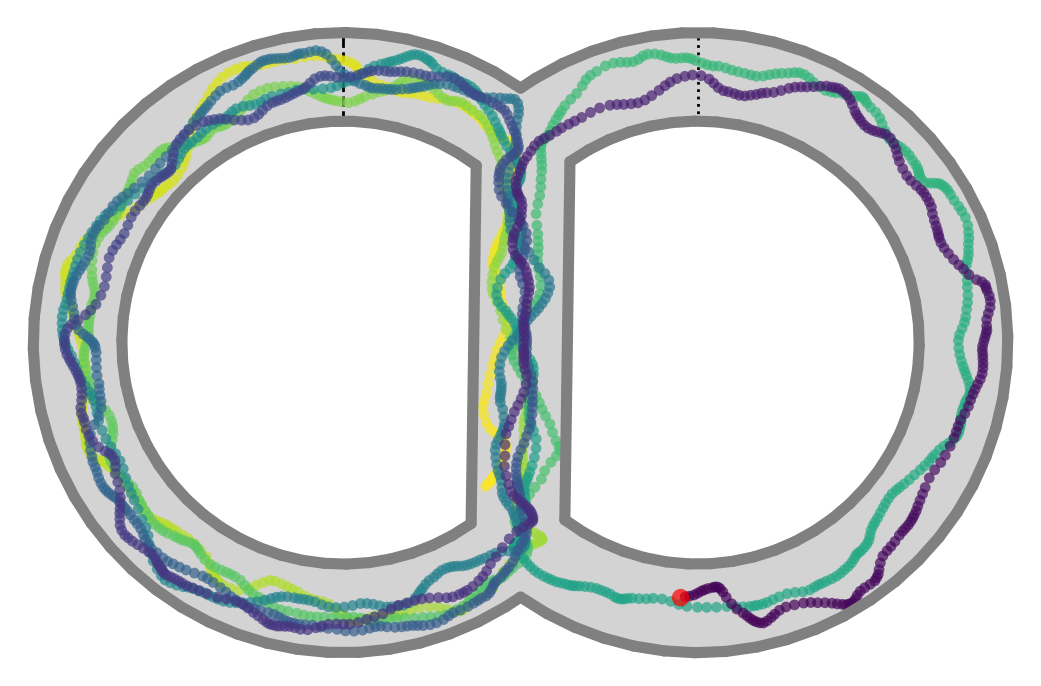

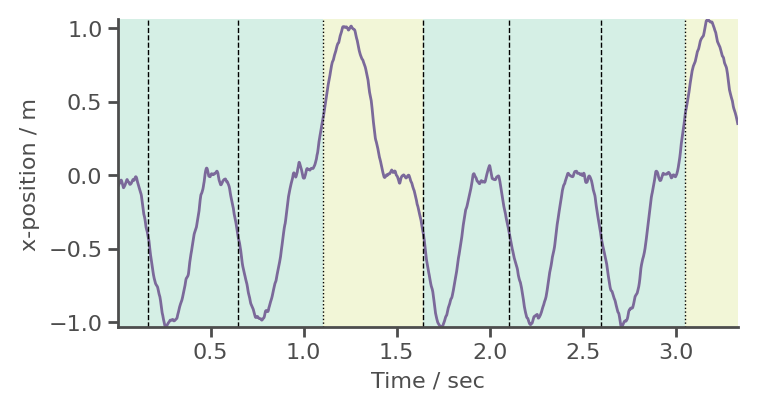

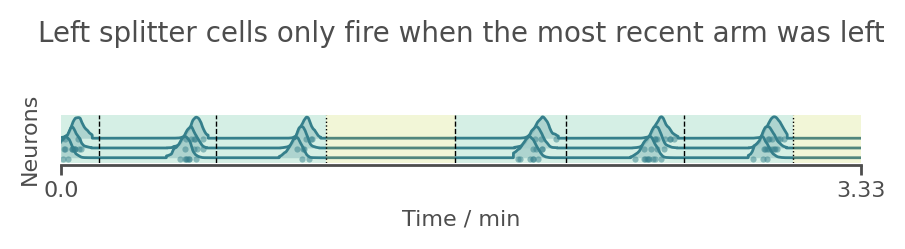

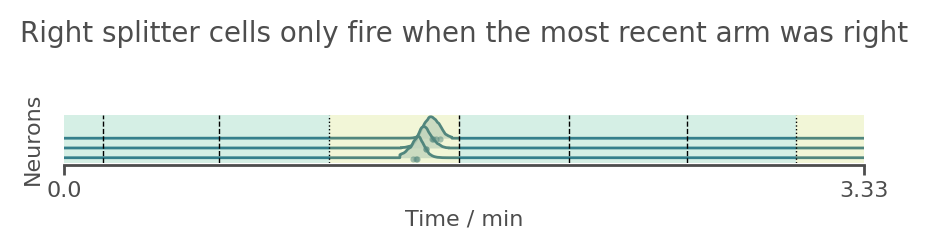

In [6]:
#Create a place cell layer for the place cells selective to the left arm
Env = Figure8Environment()
Ag = Figure8Agent(Env)
cell_centres = np.array([[0,-0.2],[0,0],[0,0.2]])
left_splitter_cells = SplitterPlaceCells(Ag, params={'arm_selectivity':'left',
                                                     'place_cell_centres':cell_centres,
                                                     'wall_geometry':'line_of_sight',
                                                     'max_fr':1,
                                                     'name':'left_splitter_cells'})
#Create a place cell layer for the place cells selective to the right arm
right_splitter_cells = SplitterPlaceCells(Ag, params={'arm_selectivity':'right',
                                                      'place_cell_centres':cell_centres,
                                                      'wall_geometry':'line_of_sight',
                                                      'max_fr':1,
                                                      'name':'right_splitter_cells'})


for i in range(int(200/Ag.dt)): 
    Ag.update()
    left_splitter_cells.update()
    right_splitter_cells.update()


fig, ax = Ag.plot_trajectory(color="changing")
fig, ax = show_1D_trajectory(Ag)


fig, ax = left_splitter_cells.plot_rate_timeseries(spikes=True)
fig, ax = display_last_arm(fig, ax, Ag)
fig.suptitle("Left splitter cells only fire when the most recent arm was left")
fig, ax = right_splitter_cells.plot_rate_timeseries(spikes=True)
fig, ax = display_last_arm(fig, ax, Ag)
fig.suptitle("Right splitter cells only fire when the most recent arm was right")

Let's check out the rate maps and see if they make sense

Figure saved to /Users/tomgeorge/Documents/RatInABox/figures/12_10_23/right_splitter_cells_ratemaps_0050.png  & .svg
Figure saved to /Users/tomgeorge/Documents/RatInABox/figures/12_10_23/right_splitter_cells_ratemaps_0050_1.png  & .svg
Figure saved to /Users/tomgeorge/Documents/RatInABox/figures/12_10_23/left_splitter_cells_ratemaps_0050_2.png  & .svg
Figure saved to /Users/tomgeorge/Documents/RatInABox/figures/12_10_23/left_splitter_cells_ratemaps_0050_3.png  & .svg


Text(0.5, 1.0, 'Left splitter cells ratemap when last lap was right')

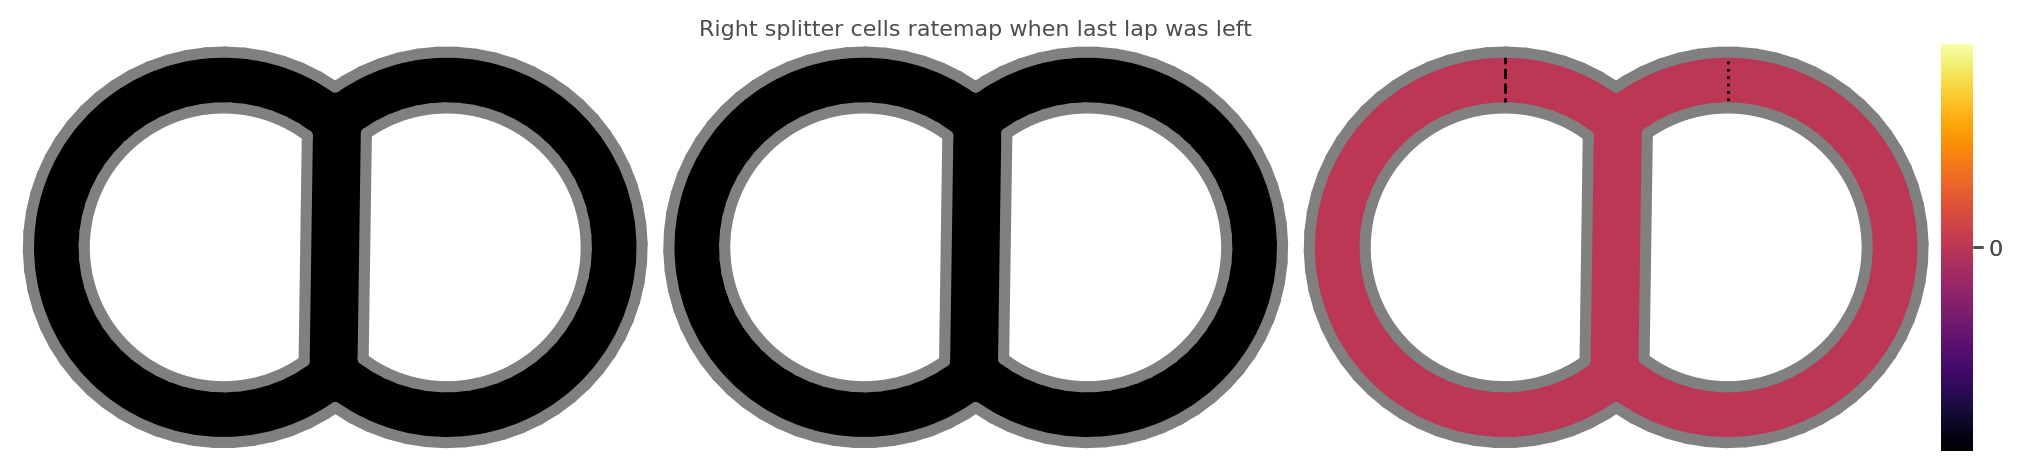

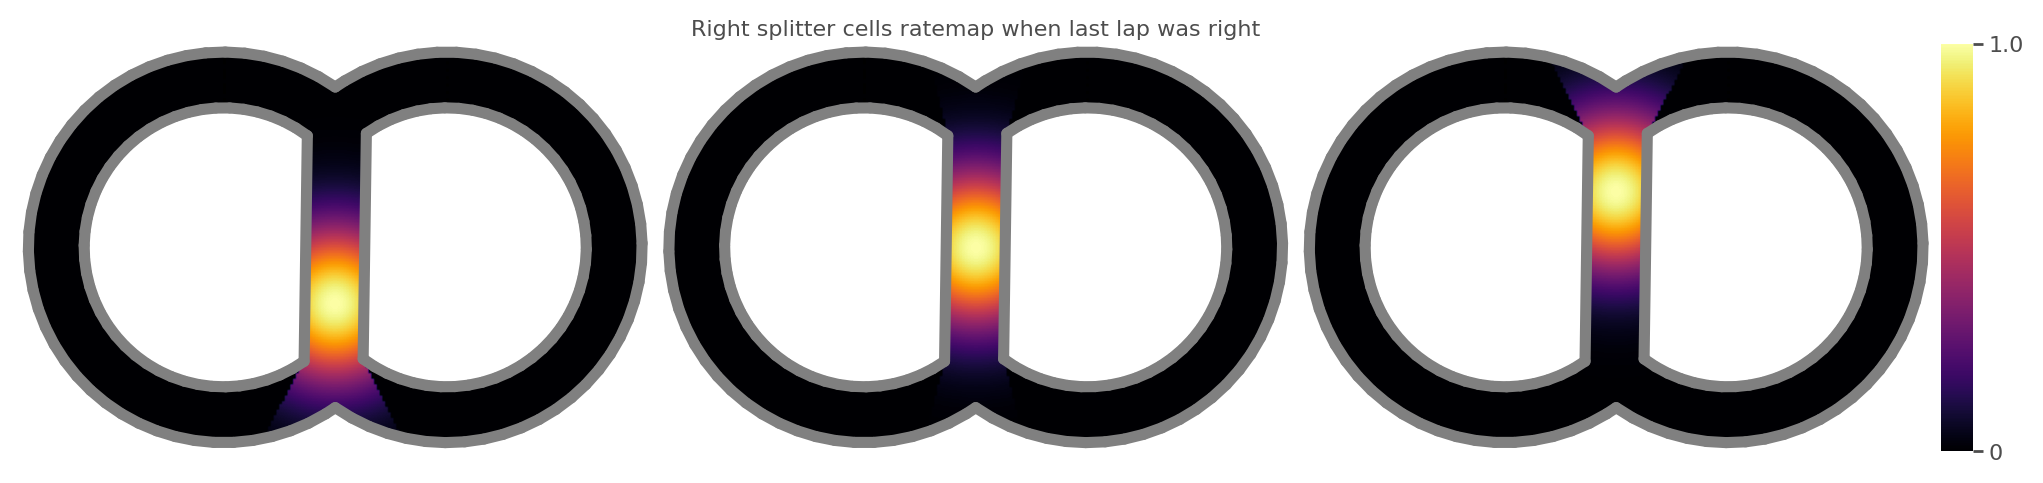

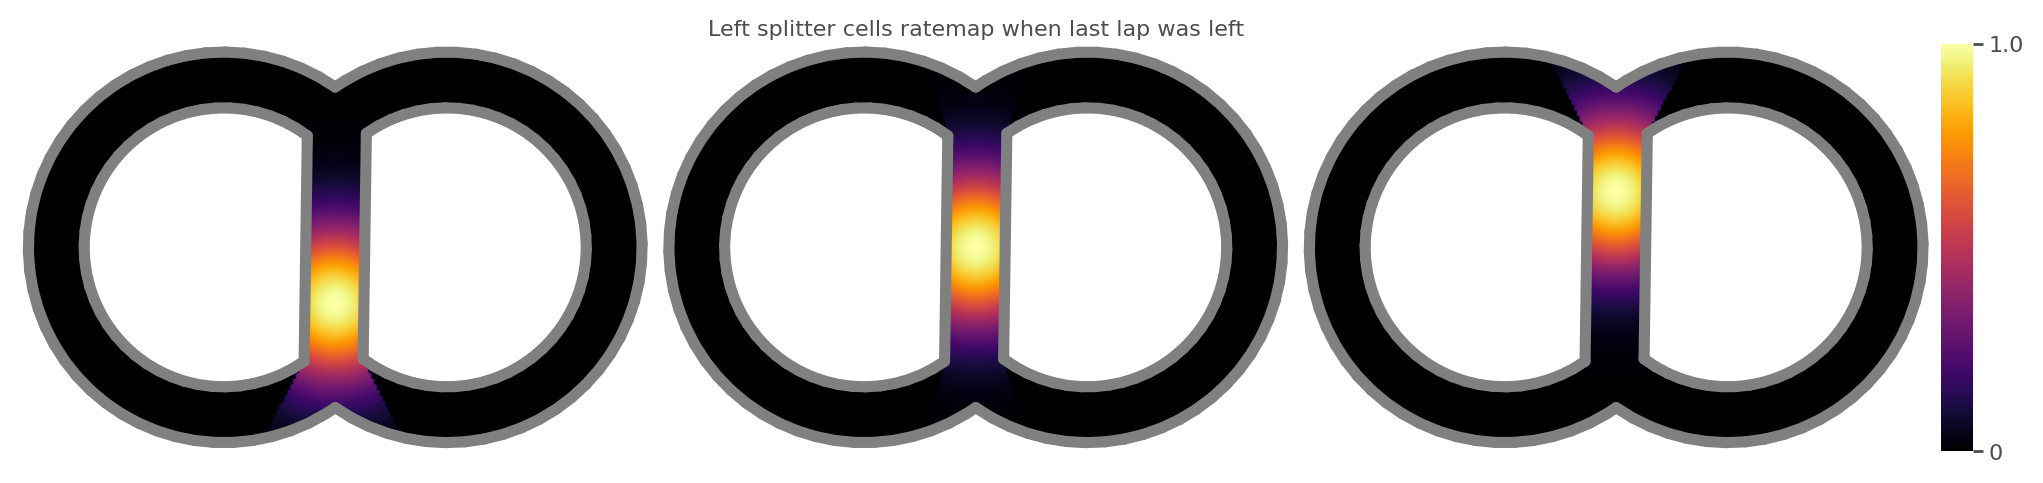

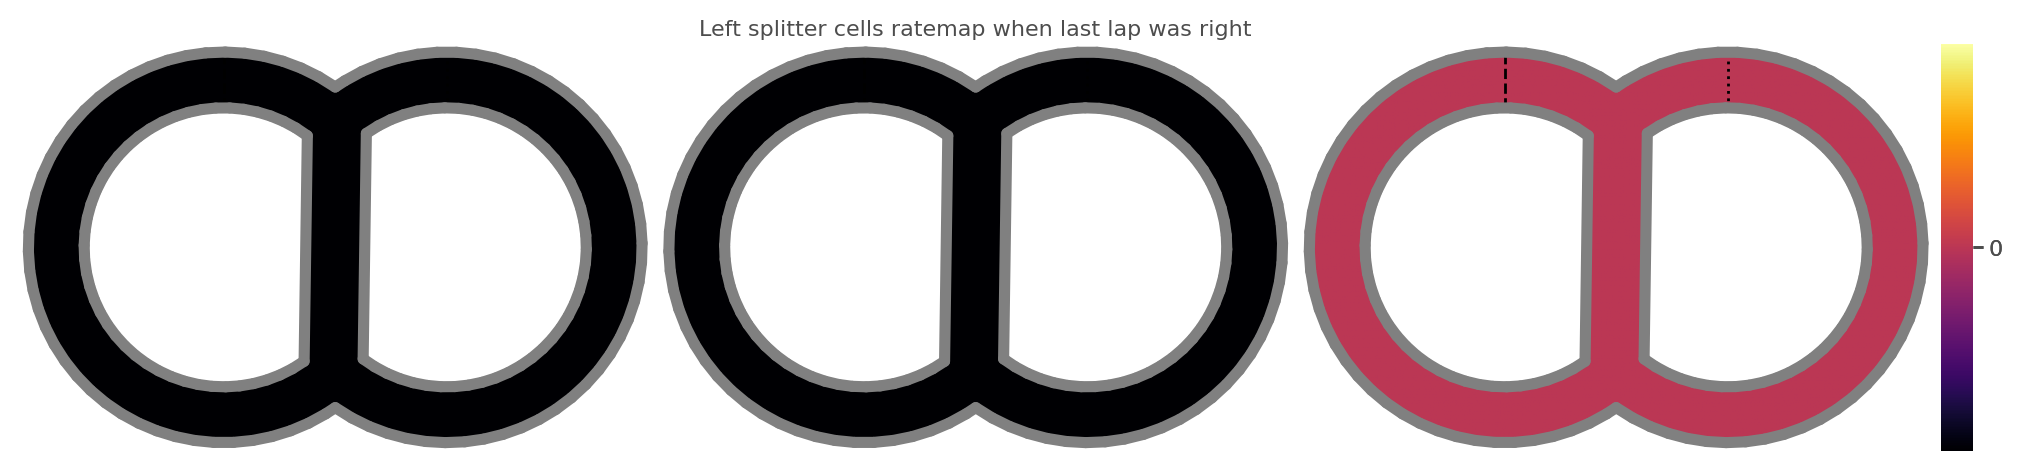

In [8]:
fig, ax = right_splitter_cells.plot_rate_map(last_lap_arm="left")
ax[1].set_title("Right splitter cells ratemap when last lap was left")

fig, ax = right_splitter_cells.plot_rate_map(last_lap_arm="right")
ax[1].set_title("Right splitter cells ratemap when last lap was right")

fig, ax = left_splitter_cells.plot_rate_map(last_lap_arm="left")
ax[1].set_title("Left splitter cells ratemap when last lap was left")

fig, ax = left_splitter_cells.plot_rate_map(last_lap_arm="right")
ax[1].set_title("Left splitter cells ratemap when last lap was right")
